# How Many Fingers?

In this replository is a small application that uses a CNN to predict how many figers you are holding up. The application does some small image manipulation to extract the edges of your hand against a plain background. It also offers functionality to collect data for training.

Data has been collected within the application by holding up 0 to 5 fingers in the region of interest and recording images. For training ~1500 images of each case has been recorded with an additional 300 images for validation.

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
import tensorflow as tf
import numpy as np
import os

# plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Using TensorFlow backend.


First let's load in the data we've collected from the program. We will use kera's `ImageDataGenerator` to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. 

In [ ]:
nbatch = 128

train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=10.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                  )
test_datagen  = ImageDataGenerator( rescale=1./255, 
        # randomizing the validation data will give a better sense of the 
        #  actual performance but adds noise also (commented out for now)
                                    #rotation_range=10.,
                                    #width_shift_range=0.1,
                                    #height_shift_range=0.1,
                                    #zoom_range=0.2,
                                    #horizontal_flip=True
                                  )

train_gen = train_datagen.flow_from_directory(
        'images/',
        target_size=(300, 300),
        color_mode='grayscale',
        batch_size=nbatch,
        classes=['NONE','ONE','TWO','THREE','FOUR','FIVE'],
        class_mode='categorical'
    )

test_gen = test_datagen.flow_from_directory(
        'test/',
        target_size=(300, 300),
        color_mode='grayscale',
        batch_size=nbatch,
        classes=['NONE','ONE','TWO','THREE','FOUR','FIVE'],
        class_mode='categorical'
    )

Next we'll do some quick checks to make sure we understand the data we will use for training

In [3]:
train_gen.class_indices

{'FIVE': 5, 'FOUR': 4, 'NONE': 0, 'ONE': 1, 'THREE': 3, 'TWO': 2}

In [4]:
test_gen.class_indices

{'FIVE': 5, 'FOUR': 4, 'NONE': 0, 'ONE': 1, 'THREE': 3, 'TWO': 2}

(128, 300, 300, 1) (128, 6)


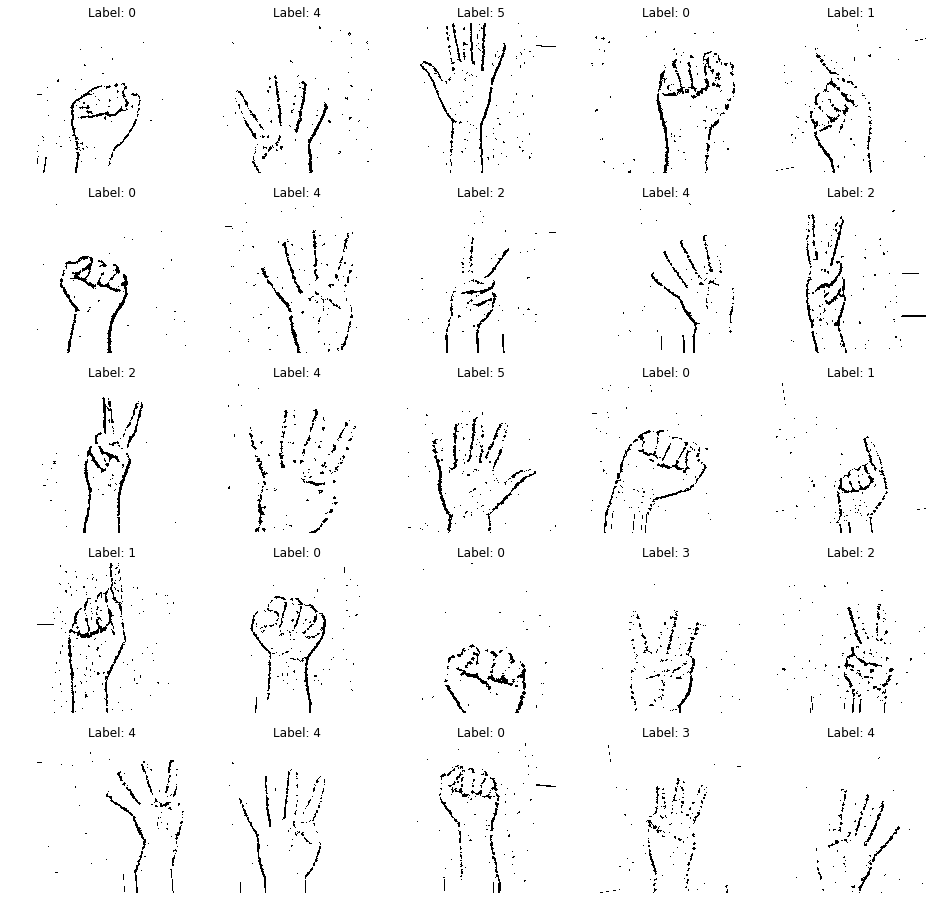

In [5]:
for X, y in train_gen:
    print(X.shape, y.shape)
    
    plt.figure(figsize=(16,16))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.title('Label: %d' % np.argmax(y[i]))
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

The data looks resonable so now we will define a CNN model to train and use within our application. The model below has not been thoroughly optimized but seems to perform well for our purposes.

In [6]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(300,300,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 128)       147584    
__________

In [7]:
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['acc'])

Finally we will train our model using some keras helper functions. No testing data has been defined as we will test the model on the fly within the application, so we will only look at the validation accuracy as a benchmark of our perfomrance for now. 

In [10]:
callbacks_list = [
    EarlyStopping(monitor='val_acc', patience=10),
    ModelCheckpoint(filepath='model_6cat.h5', monitor='val_loss', save_best_only=True),
]

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
with tf.device('/gpu:2'):
    history = model.fit_generator(
        train_gen,
        steps_per_epoch=72,
        epochs=40,
        validation_data=test_gen,
        validation_steps=2,
        callbacks=callbacks_list
    )

Epoch 1/40
72/72 [==============================] - 41s - loss: 1.3269 - acc: 0.4591 - val_loss: 1.5762 - val_acc: 0.4648
Epoch 2/40
72/72 [==============================] - 40s - loss: 0.8776 - acc: 0.6538 - val_loss: 0.6619 - val_acc: 0.6992
Epoch 3/40
72/72 [==============================] - 41s - loss: 0.5276 - acc: 0.7842 - val_loss: 0.7637 - val_acc: 0.7188
Epoch 4/40
72/72 [==============================] - 40s - loss: 0.3782 - acc: 0.8537 - val_loss: 0.5967 - val_acc: 0.7930
Epoch 5/40
72/72 [==============================] - 41s - loss: 0.2713 - acc: 0.8986 - val_loss: 0.4244 - val_acc: 0.8502
Epoch 6/40
72/72 [==============================] - 40s - loss: 0.2120 - acc: 0.9217 - val_loss: 0.7215 - val_acc: 0.8047
Epoch 7/40
72/72 [==============================] - 40s - loss: 0.1844 - acc: 0.9288 - val_loss: 0.3865 - val_acc: 0.8750
Epoch 8/40
72/72 [==============================] - 40s - loss: 0.1459 - acc: 0.9483 - val_loss: 0.3502 - val_acc: 0.8789
Epoch 9/40
72/72 [======

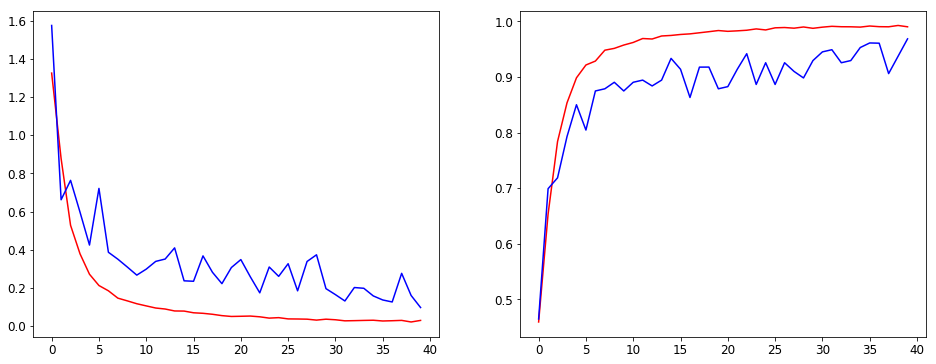

In [14]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'], 'r-')
plt.plot(range(nepochs), history.history['val_loss'], 'b-')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['acc'], 'r-')
plt.plot(range(nepochs), history.history['val_acc'], 'b-')

There's quite a bit of noise in the validation set (probably at least in part to the randomization I apply to the validation set) but with this quick training we achieve >90% accuracy and it performs satisfactorilly in application. 